# 01

In [17]:
!nvidia-smi

Sun Jan 12 16:31:39 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0              29W /  70W |   1169MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
import numpy as np
import math
import matplotlib.pyplot as plt

from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose #, BatchNormalization
from tensorflow.keras.layers import LeakyReLU

# Dis
from tensorflow.keras.layers import Flatten, Reshape, Dropout

# Gan
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [19]:
noise_dim = 100

batch_size = 64

epochs = 100

img_rows, img_cols, channels = 28, 28, 1

optimizer = Adam(0.0002, 0.5)
np.random.seed(10)

## Load data

In [20]:
(x_train, y_train), (_, _) = load_data()

x_train = (x_train.astype(np.float32) - 127.5) / 127.5

print(x_train.shape)

x_train = np.expand_dims(x_train, axis=-1)
print(x_train.shape)
print('min max:', np.min(x_train), np.max(x_train))

(60000, 28, 28)
(60000, 28, 28, 1)
min max: -1.0 1.0


In [21]:
n_samples = 6000

x_train = x_train[np.where(y_train <= 2)[0]][:n_samples]
x_train.shape

(6000, 28, 28, 1)

In [22]:
steps_per_epoch = math.ceil(n_samples / batch_size)
print('number of batches:', steps_per_epoch)

number of batches: 94


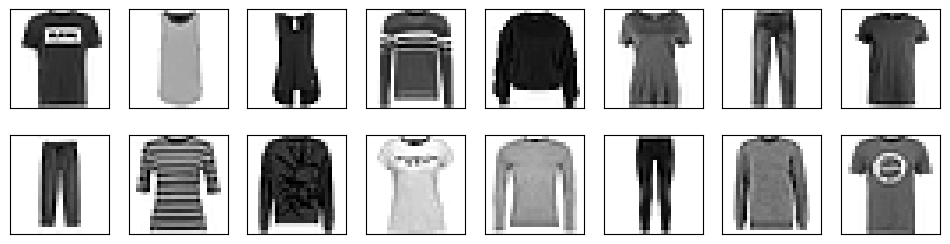

In [23]:
def visual_multi(i):
    nplots = 16
    fig = plt.figure(figsize=(12, 3))
    for j in range(nplots):
        plt.subplot(2, 8, j+1)
        plt.imshow(np.squeeze(x_train[i+j]), cmap=plt.cm.gray_r)
        plt.xticks([]); plt.yticks([])
    plt.show()

visual_multi(0)

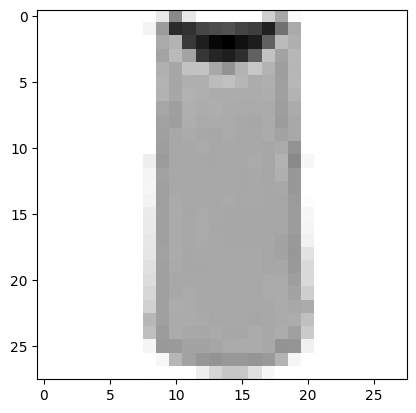

In [24]:
image = x_train[1]
plt.imshow(image.reshape((img_rows, img_cols)), cmap=plt.cm.gray_r)
plt.show()

### Generator

In [25]:
def create_generator():
    generator = Sequential()

    d = 7
    generator.add(Dense(d*d*128, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Reshape((d, d, 128)))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same'))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(64, (4, 4), strides=2, padding='same'))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh'))

    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

### Discrim

In [26]:
def create_discriminator():
    discriminator = Sequential()

    discriminator.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

## GAN

In [27]:
discriminator = create_discriminator()
generator = create_generator()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [28]:
generator.summary()
discriminator.summary()
gan.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 6272)                │         633,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 14, 14, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,027,457 (3.92 MB)

 Trainable params: 1,027,457 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,585 (389.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 99,585 (389.00 KB)

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 28, 28, 1)           │       1,027,457 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 1)                   │          99,585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,127,042 (4.30 MB)

 Trainable params: 1,027,457 (3.92 MB)

 Non-trainable params: 99,585 (389.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


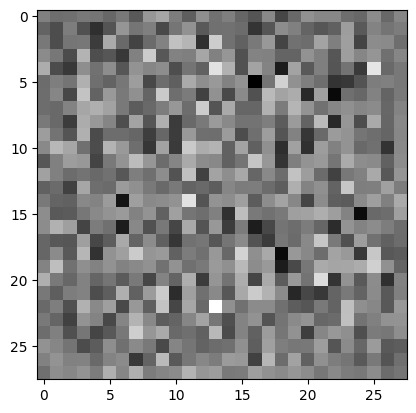

In [29]:
noise = np.random.normal(0, 1, size=(1, noise_dim))
image = generator.predict(noise)

plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
plt.show()

In [30]:
def show_images(noise, size_fig):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(size_fig[1], size_fig[0]))

    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap=plt.cm.gray_r)
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')

    plt.show()

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


  1%|          | 1/94 [00:03<04:56,  3.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  2%|▏         | 2/94 [00:03<02:14,  1.47s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  3%|▎         | 3/94 [00:03<01:23,  1.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  4%|▍         | 4/94 [00:03<00:58,  1.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  5%|▌         | 5/94 [00:04<00:45,  1.97it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▋         | 6/94 [00:04<00:37,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  7%|▋         | 7/94 [00:04<00:32,  2.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▊         | 8/94 [00:04<00:28,  3.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 10%|▉         | 9/94 [00:05<00:26,  3.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 11%|█         | 10/94 [00:05<00:24,  3.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 12%|█▏        | 11/94 [00:05<00:23,  3.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 13%|█▎        | 12/94 [00:05<00:22,  3.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 14%|█▍        | 13/94 [00:06<00:23,  3.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 15%|█▍        | 14/94 [00:06<00:25,  3.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 16%|█▌        | 15/94 [00:07<00:26,  3.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 17%|█▋        | 16/94 [00:07<00:26,  2.90it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 18%|█▊        | 17/94 [00:07<00:27,  2.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 19%|█▉        | 18/94 [00:08<00:27,  2.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 20%|██        | 19/94 [00:08<00:28,  2.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 21%|██▏       | 20/94 [00:08<00:25,  2.90it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 22%|██▏       | 21/94 [00:09<00:22,  3.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 23%|██▎       | 22/94 [00:09<00:21,  3.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 24%|██▍       | 23/94 [00:09<00:20,  3.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|██▌       | 24/94 [00:09<00:19,  3.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 27%|██▋       | 25/94 [00:10<00:18,  3.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 26/94 [00:10<00:18,  3.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 29%|██▊       | 27/94 [00:10<00:17,  3.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 30%|██▉       | 28/94 [00:10<00:17,  3.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 31%|███       | 29/94 [00:11<00:17,  3.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 32%|███▏      | 30/94 [00:11<00:17,  3.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 33%|███▎      | 31/94 [00:11<00:16,  3.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 34%|███▍      | 32/94 [00:12<00:16,  3.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 35%|███▌      | 33/94 [00:12<00:15,  3.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 36%|███▌      | 34/94 [00:12<00:15,  3.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 37%|███▋      | 35/94 [00:12<00:15,  3.86it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 38%|███▊      | 36/94 [00:13<00:14,  3.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 39%|███▉      | 37/94 [00:13<00:14,  3.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 40%|████      | 38/94 [00:13<00:14,  3.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 41%|████▏     | 39/94 [00:13<00:14,  3.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 43%|████▎     | 40/94 [00:14<00:13,  3.90it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 44%|████▎     | 41/94 [00:14<00:13,  3.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 45%|████▍     | 42/94 [00:14<00:13,  3.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 46%|████▌     | 43/94 [00:14<00:13,  3.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 47%|████▋     | 44/94 [00:15<00:12,  3.90it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 48%|████▊     | 45/94 [00:15<00:12,  3.90it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 49%|████▉     | 46/94 [00:15<00:12,  3.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 50%|█████     | 47/94 [00:15<00:12,  3.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 51%|█████     | 48/94 [00:16<00:12,  3.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 52%|█████▏    | 49/94 [00:16<00:11,  3.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 53%|█████▎    | 50/94 [00:16<00:11,  3.86it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 54%|█████▍    | 51/94 [00:16<00:11,  3.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 55%|█████▌    | 52/94 [00:17<00:11,  3.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|█████▋    | 53/94 [00:17<00:10,  3.77it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████▋    | 54/94 [00:17<00:10,  3.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 59%|█████▊    | 55/94 [00:17<00:10,  3.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 60%|█████▉    | 56/94 [00:18<00:09,  3.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|██████    | 57/94 [00:18<00:09,  3.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 62%|██████▏   | 58/94 [00:18<00:10,  3.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████▎   | 59/94 [00:19<00:10,  3.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 64%|██████▍   | 60/94 [00:19<00:11,  2.99it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 65%|██████▍   | 61/94 [00:20<00:11,  2.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 66%|██████▌   | 62/94 [00:20<00:11,  2.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 67%|██████▋   | 63/94 [00:20<00:11,  2.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 68%|██████▊   | 64/94 [00:21<00:11,  2.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 69%|██████▉   | 65/94 [00:21<00:10,  2.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 70%|███████   | 66/94 [00:21<00:09,  3.05it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 71%|███████▏  | 67/94 [00:22<00:08,  3.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 72%|███████▏  | 68/94 [00:22<00:07,  3.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|███████▎  | 69/94 [00:22<00:09,  2.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 74%|███████▍  | 70/94 [00:23<00:08,  2.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|███████▌  | 71/94 [00:23<00:07,  3.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|███████▋  | 72/94 [00:23<00:06,  3.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 78%|███████▊  | 73/94 [00:23<00:06,  3.47it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 79%|███████▊  | 74/94 [00:24<00:05,  3.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 80%|███████▉  | 75/94 [00:24<00:05,  3.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 76/94 [00:24<00:05,  3.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|████████▏ | 77/94 [00:24<00:04,  3.65it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|████████▎ | 78/94 [00:25<00:04,  3.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▍ | 79/94 [00:25<00:04,  3.67it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|████████▌ | 80/94 [00:25<00:03,  3.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 86%|████████▌ | 81/94 [00:26<00:03,  3.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 87%|████████▋ | 82/94 [00:26<00:03,  3.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 88%|████████▊ | 83/94 [00:26<00:02,  3.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 89%|████████▉ | 84/94 [00:26<00:02,  3.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 90%|█████████ | 85/94 [00:27<00:02,  3.71it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 91%|█████████▏| 86/94 [00:27<00:02,  3.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 93%|█████████▎| 87/94 [00:27<00:01,  3.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 94%|█████████▎| 88/94 [00:27<00:01,  3.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 95%|█████████▍| 89/94 [00:28<00:01,  3.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 96%|█████████▌| 90/94 [00:28<00:01,  3.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 97%|█████████▋| 91/94 [00:28<00:00,  3.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 98%|█████████▊| 92/94 [00:29<00:00,  3.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 99%|█████████▉| 93/94 [00:29<00:00,  3.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


100%|██████████| 94/94 [00:29<00:00,  3.18it/s]


Epoch: 1/100 	 Discriminator Loss: 0.776     Generator Loss: 0.776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


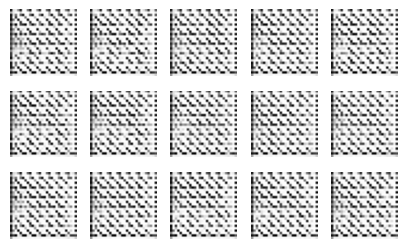

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 1/94 [00:00<00:25,  3.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  2%|▏         | 2/94 [00:00<00:24,  3.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  3%|▎         | 3/94 [00:00<00:25,  3.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  4%|▍         | 4/94 [00:01<00:29,  3.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  5%|▌         | 5/94 [00:01<00:30,  2.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▋         | 6/94 [00:02<00:32,  2.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 7/94 [00:02<00:32,  2.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  9%|▊         | 8/94 [00:02<00:33,  2.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 10%|▉         | 9/94 [00:03<00:34,  2.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 11%|█         | 10/94 [00:03<00:34,  2.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 12%|█▏        | 11/94 [00:03<00:30,  2.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 13%|█▎        | 12/94 [00:04<00:28,  2.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 14%|█▍        | 13/94 [00:04<00:26,  3.07it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 15%|█▍        | 14/94 [00:04<00:24,  3.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 16%|█▌        | 15/94 [00:05<00:24,  3.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 17%|█▋        | 16/94 [00:05<00:22,  3.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|█▊        | 17/94 [00:05<00:21,  3.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|█▉        | 18/94 [00:05<00:21,  3.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 20%|██        | 19/94 [00:06<00:21,  3.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 21%|██▏       | 20/94 [00:06<00:20,  3.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 22%|██▏       | 21/94 [00:06<00:20,  3.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 23%|██▎       | 22/94 [00:07<00:20,  3.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 24%|██▍       | 23/94 [00:07<00:19,  3.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 26%|██▌       | 24/94 [00:07<00:19,  3.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 27%|██▋       | 25/94 [00:07<00:19,  3.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 26/94 [00:08<00:19,  3.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 29%|██▊       | 27/94 [00:08<00:18,  3.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 30%|██▉       | 28/94 [00:08<00:18,  3.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 31%|███       | 29/94 [00:08<00:18,  3.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 32%|███▏      | 30/94 [00:09<00:18,  3.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 33%|███▎      | 31/94 [00:09<00:17,  3.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 34%|███▍      | 32/94 [00:09<00:17,  3.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 35%|███▌      | 33/94 [00:10<00:19,  3.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 36%|███▌      | 34/94 [00:10<00:18,  3.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|███▋      | 35/94 [00:10<00:18,  3.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 38%|███▊      | 36/94 [00:11<00:18,  3.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 39%|███▉      | 37/94 [00:11<00:17,  3.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 40%|████      | 38/94 [00:11<00:18,  3.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 41%|████▏     | 39/94 [00:12<00:17,  3.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 40/94 [00:12<00:16,  3.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 44%|████▎     | 41/94 [00:12<00:15,  3.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 45%|████▍     | 42/94 [00:12<00:15,  3.46it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 46%|████▌     | 43/94 [00:13<00:14,  3.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|████▋     | 44/94 [00:13<00:14,  3.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 48%|████▊     | 45/94 [00:13<00:14,  3.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 49%|████▉     | 46/94 [00:14<00:16,  2.98it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 50%|█████     | 47/94 [00:14<00:17,  2.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 51%|█████     | 48/94 [00:15<00:17,  2.64it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 52%|█████▏    | 49/94 [00:15<00:17,  2.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 53%|█████▎    | 50/94 [00:15<00:18,  2.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 54%|█████▍    | 51/94 [00:16<00:18,  2.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|█████▌    | 52/94 [00:16<00:15,  2.64it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|█████▋    | 53/94 [00:16<00:14,  2.90it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 57%|█████▋    | 54/94 [00:17<00:12,  3.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 59%|█████▊    | 55/94 [00:17<00:12,  3.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 60%|█████▉    | 56/94 [00:17<00:11,  3.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|██████    | 57/94 [00:18<00:11,  3.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|██████▏   | 58/94 [00:18<00:10,  3.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████▎   | 59/94 [00:18<00:10,  3.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 64%|██████▍   | 60/94 [00:18<00:09,  3.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|██████▍   | 61/94 [00:19<00:09,  3.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|██████▌   | 62/94 [00:19<00:09,  3.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 67%|██████▋   | 63/94 [00:19<00:08,  3.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 64/94 [00:20<00:08,  3.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 69%|██████▉   | 65/94 [00:20<00:08,  3.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 70%|███████   | 66/94 [00:20<00:07,  3.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|███████▏  | 67/94 [00:20<00:07,  3.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|███████▏  | 68/94 [00:21<00:07,  3.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|███████▎  | 69/94 [00:21<00:07,  3.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 74%|███████▍  | 70/94 [00:21<00:06,  3.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|███████▌  | 71/94 [00:22<00:06,  3.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|███████▋  | 72/94 [00:22<00:06,  3.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|███████▊  | 73/94 [00:22<00:05,  3.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████▊  | 74/94 [00:22<00:05,  3.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 80%|███████▉  | 75/94 [00:23<00:05,  3.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 76/94 [00:23<00:05,  3.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|████████▏ | 77/94 [00:23<00:04,  3.46it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|████████▎ | 78/94 [00:24<00:04,  3.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 84%|████████▍ | 79/94 [00:24<00:04,  3.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|████████▌ | 80/94 [00:24<00:04,  3.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 86%|████████▌ | 81/94 [00:24<00:03,  3.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 87%|████████▋ | 82/94 [00:25<00:03,  3.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 88%|████████▊ | 83/94 [00:25<00:03,  3.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 89%|████████▉ | 84/94 [00:25<00:02,  3.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 90%|█████████ | 85/94 [00:26<00:02,  3.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 91%|█████████▏| 86/94 [00:26<00:02,  3.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 93%|█████████▎| 87/94 [00:26<00:02,  2.95it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 94%|█████████▎| 88/94 [00:27<00:02,  2.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 95%|█████████▍| 89/94 [00:27<00:01,  2.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 96%|█████████▌| 90/94 [00:28<00:01,  2.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 97%|█████████▋| 91/94 [00:28<00:01,  2.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 98%|█████████▊| 92/94 [00:29<00:00,  2.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 99%|█████████▉| 93/94 [00:29<00:00,  2.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


100%|██████████| 94/94 [00:29<00:00,  3.17it/s]

Epoch: 2/100 	 Discriminator Loss: 0.866     Generator Loss: 0.866
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


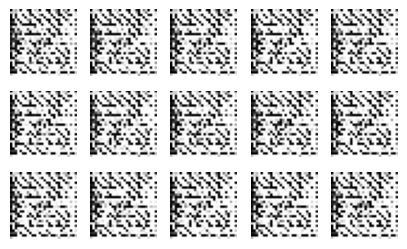

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  1%|          | 1/94 [00:00<00:30,  3.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  2%|▏         | 2/94 [00:00<00:28,  3.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  3%|▎         | 3/94 [00:00<00:27,  3.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  4%|▍         | 4/94 [00:01<00:26,  3.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  5%|▌         | 5/94 [00:01<00:26,  3.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▋         | 6/94 [00:01<00:26,  3.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  7%|▋         | 7/94 [00:02<00:25,  3.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▊         | 8/94 [00:02<00:25,  3.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|▉         | 9/94 [00:02<00:25,  3.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 11%|█         | 10/94 [00:02<00:24,  3.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 12%|█▏        | 11/94 [00:03<00:24,  3.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 13%|█▎        | 12/94 [00:03<00:24,  3.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 14%|█▍        | 13/94 [00:03<00:24,  3.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 15%|█▍        | 14/94 [00:04<00:23,  3.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 16%|█▌        | 15/94 [00:04<00:23,  3.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 17%|█▋        | 16/94 [00:04<00:23,  3.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 18%|█▊        | 17/94 [00:05<00:22,  3.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 19%|█▉        | 18/94 [00:05<00:22,  3.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 20%|██        | 19/94 [00:05<00:21,  3.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 21%|██▏       | 20/94 [00:05<00:21,  3.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 22%|██▏       | 21/94 [00:06<00:21,  3.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 23%|██▎       | 22/94 [00:06<00:21,  3.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 24%|██▍       | 23/94 [00:06<00:21,  3.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|██▌       | 24/94 [00:07<00:20,  3.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|██▋       | 25/94 [00:07<00:20,  3.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 28%|██▊       | 26/94 [00:07<00:19,  3.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|██▊       | 27/94 [00:08<00:20,  3.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 30%|██▉       | 28/94 [00:08<00:19,  3.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|███       | 29/94 [00:08<00:19,  3.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 32%|███▏      | 30/94 [00:08<00:19,  3.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 33%|███▎      | 31/94 [00:09<00:21,  2.99it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 34%|███▍      | 32/94 [00:09<00:22,  2.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 35%|███▌      | 33/94 [00:10<00:23,  2.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 36%|███▌      | 34/94 [00:10<00:23,  2.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|███▋      | 35/94 [00:11<00:24,  2.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 38%|███▊      | 36/94 [00:11<00:24,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 39%|███▉      | 37/94 [00:11<00:24,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 40%|████      | 38/94 [00:12<00:21,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 41%|████▏     | 39/94 [00:12<00:19,  2.77it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 43%|████▎     | 40/94 [00:12<00:18,  2.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 44%|████▎     | 41/94 [00:13<00:17,  3.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 45%|████▍     | 42/94 [00:13<00:16,  3.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 46%|████▌     | 43/94 [00:13<00:15,  3.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 47%|████▋     | 44/94 [00:14<00:15,  3.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 48%|████▊     | 45/94 [00:14<00:14,  3.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▉     | 46/94 [00:14<00:14,  3.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 50%|█████     | 47/94 [00:14<00:14,  3.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 48/94 [00:15<00:13,  3.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 52%|█████▏    | 49/94 [00:15<00:13,  3.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 53%|█████▎    | 50/94 [00:15<00:13,  3.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 54%|█████▍    | 51/94 [00:16<00:12,  3.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 55%|█████▌    | 52/94 [00:16<00:12,  3.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 56%|█████▋    | 53/94 [00:16<00:12,  3.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████▋    | 54/94 [00:16<00:11,  3.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 59%|█████▊    | 55/94 [00:17<00:11,  3.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 60%|█████▉    | 56/94 [00:17<00:11,  3.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|██████    | 57/94 [00:17<00:11,  3.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|██████▏   | 58/94 [00:18<00:10,  3.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████▎   | 59/94 [00:18<00:10,  3.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 64%|██████▍   | 60/94 [00:18<00:10,  3.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 65%|██████▍   | 61/94 [00:19<00:10,  3.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|██████▌   | 62/94 [00:19<00:09,  3.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 67%|██████▋   | 63/94 [00:19<00:09,  3.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 64/94 [00:20<00:09,  3.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 69%|██████▉   | 65/94 [00:20<00:08,  3.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|███████   | 66/94 [00:20<00:08,  3.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|███████▏  | 67/94 [00:20<00:08,  3.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|███████▏  | 68/94 [00:21<00:07,  3.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 73%|███████▎  | 69/94 [00:21<00:07,  3.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 74%|███████▍  | 70/94 [00:21<00:07,  3.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|███████▌  | 71/94 [00:22<00:07,  2.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|███████▋  | 72/94 [00:22<00:08,  2.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 78%|███████▊  | 73/94 [00:23<00:08,  2.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 79%|███████▊  | 74/94 [00:23<00:08,  2.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 80%|███████▉  | 75/94 [00:24<00:08,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 76/94 [00:24<00:07,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 82%|████████▏ | 77/94 [00:24<00:07,  2.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 83%|████████▎ | 78/94 [00:25<00:06,  2.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 84%|████████▍ | 79/94 [00:25<00:05,  2.78it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 85%|████████▌ | 80/94 [00:25<00:04,  2.91it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 86%|████████▌ | 81/94 [00:26<00:04,  3.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 87%|████████▋ | 82/94 [00:26<00:03,  3.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 88%|████████▊ | 83/94 [00:26<00:03,  3.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 89%|████████▉ | 84/94 [00:27<00:03,  3.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 90%|█████████ | 85/94 [00:27<00:02,  3.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 91%|█████████▏| 86/94 [00:27<00:02,  3.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 93%|█████████▎| 87/94 [00:28<00:02,  3.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 94%|█████████▎| 88/94 [00:28<00:01,  3.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 95%|█████████▍| 89/94 [00:28<00:01,  3.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 96%|█████████▌| 90/94 [00:28<00:01,  3.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 97%|█████████▋| 91/94 [00:29<00:00,  3.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 98%|█████████▊| 92/94 [00:29<00:00,  3.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 99%|█████████▉| 93/94 [00:29<00:00,  3.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


100%|██████████| 94/94 [00:30<00:00,  3.11it/s]

Epoch: 3/100 	 Discriminator Loss: 0.939     Generator Loss: 0.939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


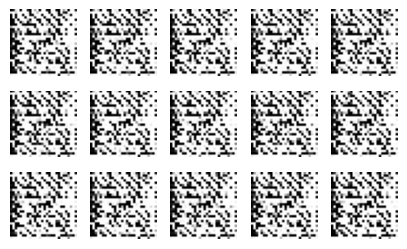

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 1/94 [00:00<00:33,  2.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  2%|▏         | 2/94 [00:00<00:29,  3.07it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  3%|▎         | 3/94 [00:00<00:29,  3.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  4%|▍         | 4/94 [00:01<00:28,  3.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  5%|▌         | 5/94 [00:01<00:28,  3.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  6%|▋         | 6/94 [00:01<00:28,  3.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 7/94 [00:02<00:28,  3.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▊         | 8/94 [00:02<00:27,  3.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 10%|▉         | 9/94 [00:02<00:26,  3.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 11%|█         | 10/94 [00:03<00:26,  3.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 12%|█▏        | 11/94 [00:03<00:26,  3.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|█▎        | 12/94 [00:03<00:25,  3.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 14%|█▍        | 13/94 [00:04<00:25,  3.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 15%|█▍        | 14/94 [00:04<00:27,  2.95it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 16%|█▌        | 15/94 [00:04<00:29,  2.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 17%|█▋        | 16/94 [00:05<00:30,  2.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 18%|█▊        | 17/94 [00:05<00:31,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|█▉        | 18/94 [00:06<00:32,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 20%|██        | 19/94 [00:06<00:33,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 21%|██▏       | 20/94 [00:07<00:32,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 22%|██▏       | 21/94 [00:07<00:29,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 23%|██▎       | 22/94 [00:07<00:26,  2.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 24%|██▍       | 23/94 [00:08<00:25,  2.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|██▌       | 24/94 [00:08<00:24,  2.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|██▋       | 25/94 [00:08<00:23,  2.99it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 26/94 [00:09<00:22,  3.07it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 29%|██▊       | 27/94 [00:09<00:22,  3.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 30%|██▉       | 28/94 [00:09<00:21,  3.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 31%|███       | 29/94 [00:10<00:20,  3.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 32%|███▏      | 30/94 [00:10<00:20,  3.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 33%|███▎      | 31/94 [00:10<00:20,  3.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███▍      | 32/94 [00:11<00:19,  3.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 35%|███▌      | 33/94 [00:11<00:19,  3.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 36%|███▌      | 34/94 [00:11<00:18,  3.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 37%|███▋      | 35/94 [00:11<00:18,  3.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 38%|███▊      | 36/94 [00:12<00:18,  3.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 39%|███▉      | 37/94 [00:12<00:18,  3.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 40%|████      | 38/94 [00:12<00:17,  3.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 41%|████▏     | 39/94 [00:13<00:17,  3.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 43%|████▎     | 40/94 [00:13<00:17,  3.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 44%|████▎     | 41/94 [00:13<00:16,  3.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 45%|████▍     | 42/94 [00:14<00:16,  3.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 46%|████▌     | 43/94 [00:14<00:16,  3.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|████▋     | 44/94 [00:14<00:15,  3.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 48%|████▊     | 45/94 [00:15<00:15,  3.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 49%|████▉     | 46/94 [00:15<00:15,  3.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 50%|█████     | 47/94 [00:15<00:14,  3.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 48/94 [00:16<00:14,  3.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 52%|█████▏    | 49/94 [00:16<00:14,  3.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 53%|█████▎    | 50/94 [00:17<00:18,  2.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 54%|█████▍    | 51/94 [00:17<00:19,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|█████▌    | 52/94 [00:18<00:18,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|█████▋    | 53/94 [00:18<00:18,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 57%|█████▋    | 54/94 [00:18<00:18,  2.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 59%|█████▊    | 55/94 [00:19<00:18,  2.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 60%|█████▉    | 56/94 [00:19<00:18,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|██████    | 57/94 [00:20<00:16,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|██████▏   | 58/94 [00:20<00:14,  2.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 63%|██████▎   | 59/94 [00:20<00:13,  2.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 64%|██████▍   | 60/94 [00:21<00:12,  2.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|██████▍   | 61/94 [00:21<00:11,  2.92it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|██████▌   | 62/94 [00:21<00:10,  2.95it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 67%|██████▋   | 63/94 [00:22<00:10,  3.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 68%|██████▊   | 64/94 [00:22<00:09,  3.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 69%|██████▉   | 65/94 [00:22<00:09,  3.03it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 70%|███████   | 66/94 [00:23<00:09,  3.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 71%|███████▏  | 67/94 [00:23<00:08,  3.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|███████▏  | 68/94 [00:23<00:08,  3.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|███████▎  | 69/94 [00:24<00:08,  3.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 74%|███████▍  | 70/94 [00:24<00:07,  3.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 76%|███████▌  | 71/94 [00:24<00:07,  3.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|███████▋  | 72/94 [00:25<00:07,  3.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|███████▊  | 73/94 [00:25<00:06,  3.05it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████▊  | 74/94 [00:25<00:06,  3.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 80%|███████▉  | 75/94 [00:26<00:06,  3.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 76/94 [00:26<00:05,  3.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|████████▏ | 77/94 [00:26<00:05,  3.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 83%|████████▎ | 78/94 [00:27<00:05,  3.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 84%|████████▍ | 79/94 [00:27<00:04,  3.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|████████▌ | 80/94 [00:27<00:04,  3.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 86%|████████▌ | 81/94 [00:28<00:04,  3.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 87%|████████▋ | 82/94 [00:28<00:03,  3.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 88%|████████▊ | 83/94 [00:28<00:03,  3.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 89%|████████▉ | 84/94 [00:29<00:03,  3.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 90%|█████████ | 85/94 [00:29<00:02,  3.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 91%|█████████▏| 86/94 [00:29<00:02,  3.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 93%|█████████▎| 87/94 [00:30<00:02,  3.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 94%|█████████▎| 88/94 [00:30<00:02,  2.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 95%|█████████▍| 89/94 [00:30<00:02,  2.46it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 96%|█████████▌| 90/94 [00:31<00:01,  2.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 97%|█████████▋| 91/94 [00:31<00:01,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 98%|█████████▊| 92/94 [00:32<00:00,  2.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 99%|█████████▉| 93/94 [00:32<00:00,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


100%|██████████| 94/94 [00:33<00:00,  2.82it/s]

Epoch: 4/100 	 Discriminator Loss: 0.989     Generator Loss: 0.989
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


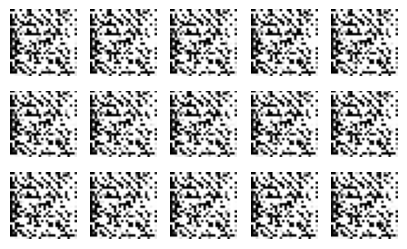

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  1%|          | 1/94 [00:00<00:33,  2.77it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  2%|▏         | 2/94 [00:00<00:33,  2.71it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  3%|▎         | 3/94 [00:01<00:31,  2.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▍         | 4/94 [00:01<00:30,  2.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  5%|▌         | 5/94 [00:01<00:30,  2.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  6%|▋         | 6/94 [00:02<00:29,  3.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  7%|▋         | 7/94 [00:02<00:28,  3.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  9%|▊         | 8/94 [00:02<00:28,  3.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 10%|▉         | 9/94 [00:03<00:28,  3.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 11%|█         | 10/94 [00:03<00:27,  3.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 12%|█▏        | 11/94 [00:03<00:27,  2.99it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 13%|█▎        | 12/94 [00:04<00:27,  3.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 14%|█▍        | 13/94 [00:04<00:26,  3.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 15%|█▍        | 14/94 [00:04<00:26,  3.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 16%|█▌        | 15/94 [00:05<00:25,  3.05it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 17%|█▋        | 16/94 [00:05<00:25,  3.05it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|█▊        | 17/94 [00:05<00:25,  3.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 19%|█▉        | 18/94 [00:06<00:25,  3.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 20%|██        | 19/94 [00:06<00:24,  3.03it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 21%|██▏       | 20/94 [00:06<00:24,  3.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 22%|██▏       | 21/94 [00:07<00:24,  3.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 23%|██▎       | 22/94 [00:07<00:23,  3.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 24%|██▍       | 23/94 [00:07<00:23,  2.96it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 26%|██▌       | 24/94 [00:08<00:23,  3.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|██▋       | 25/94 [00:08<00:22,  3.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 28%|██▊       | 26/94 [00:08<00:23,  2.96it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 29%|██▊       | 27/94 [00:09<00:22,  3.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 30%|██▉       | 28/94 [00:09<00:22,  2.91it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 31%|███       | 29/94 [00:09<00:25,  2.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 32%|███▏      | 30/94 [00:10<00:26,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 33%|███▎      | 31/94 [00:10<00:27,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 34%|███▍      | 32/94 [00:11<00:28,  2.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 35%|███▌      | 33/94 [00:11<00:28,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 36%|███▌      | 34/94 [00:12<00:27,  2.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 37%|███▋      | 35/94 [00:12<00:25,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 38%|███▊      | 36/94 [00:12<00:23,  2.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 39%|███▉      | 37/94 [00:13<00:21,  2.65it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|████      | 38/94 [00:13<00:20,  2.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 41%|████▏     | 39/94 [00:13<00:19,  2.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 43%|████▎     | 40/94 [00:14<00:21,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▎     | 41/94 [00:15<00:25,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 45%|████▍     | 42/94 [00:15<00:28,  1.85it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 46%|████▌     | 43/94 [00:16<00:29,  1.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 47%|████▋     | 44/94 [00:17<00:31,  1.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 48%|████▊     | 45/94 [00:17<00:30,  1.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 49%|████▉     | 46/94 [00:18<00:26,  1.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 50%|█████     | 47/94 [00:18<00:22,  2.07it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 51%|█████     | 48/94 [00:18<00:20,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 52%|█████▏    | 49/94 [00:19<00:18,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 53%|█████▎    | 50/94 [00:19<00:16,  2.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 54%|█████▍    | 51/94 [00:19<00:15,  2.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 55%|█████▌    | 52/94 [00:20<00:15,  2.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 56%|█████▋    | 53/94 [00:20<00:14,  2.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 57%|█████▋    | 54/94 [00:20<00:14,  2.85it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 59%|█████▊    | 55/94 [00:21<00:13,  2.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 60%|█████▉    | 56/94 [00:21<00:13,  2.91it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 61%|██████    | 57/94 [00:21<00:12,  2.92it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 62%|██████▏   | 58/94 [00:22<00:12,  2.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 63%|██████▎   | 59/94 [00:22<00:13,  2.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 64%|██████▍   | 60/94 [00:23<00:14,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 65%|██████▍   | 61/94 [00:23<00:14,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 66%|██████▌   | 62/94 [00:24<00:14,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 67%|██████▋   | 63/94 [00:24<00:14,  2.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 64/94 [00:25<00:13,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 69%|██████▉   | 65/94 [00:25<00:11,  2.46it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|███████   | 66/94 [00:25<00:10,  2.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|███████▏  | 67/94 [00:26<00:09,  2.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|███████▏  | 68/94 [00:26<00:09,  2.76it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|███████▎  | 69/94 [00:26<00:08,  2.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 74%|███████▍  | 70/94 [00:27<00:08,  2.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 76%|███████▌  | 71/94 [00:27<00:08,  2.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 77%|███████▋  | 72/94 [00:27<00:07,  2.77it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|███████▊  | 73/94 [00:28<00:07,  2.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████▊  | 74/94 [00:28<00:07,  2.78it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 80%|███████▉  | 75/94 [00:28<00:06,  2.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 76/94 [00:29<00:06,  2.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 82%|████████▏ | 77/94 [00:29<00:05,  2.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|████████▎ | 78/94 [00:29<00:05,  2.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 84%|████████▍ | 79/94 [00:30<00:05,  2.96it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 85%|████████▌ | 80/94 [00:30<00:04,  2.92it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 86%|████████▌ | 81/94 [00:31<00:04,  2.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 87%|████████▋ | 82/94 [00:31<00:04,  2.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 88%|████████▊ | 83/94 [00:31<00:03,  2.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 89%|████████▉ | 84/94 [00:32<00:03,  2.91it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 90%|█████████ | 85/94 [00:32<00:03,  2.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 91%|█████████▏| 86/94 [00:32<00:02,  2.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 93%|█████████▎| 87/94 [00:33<00:02,  2.91it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 94%|█████████▎| 88/94 [00:33<00:02,  2.95it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 95%|█████████▍| 89/94 [00:33<00:01,  2.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 96%|█████████▌| 90/94 [00:34<00:01,  2.92it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 97%|█████████▋| 91/94 [00:34<00:01,  2.92it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 98%|█████████▊| 92/94 [00:34<00:00,  2.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 99%|█████████▉| 93/94 [00:35<00:00,  2.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


100%|██████████| 94/94 [00:35<00:00,  2.63it/s]

Epoch: 5/100 	 Discriminator Loss: 1.028     Generator Loss: 1.028
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


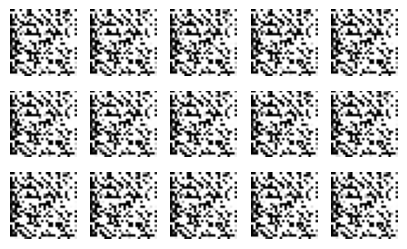

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  1%|          | 1/94 [00:00<00:50,  1.86it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  2%|▏         | 2/94 [00:01<00:50,  1.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  3%|▎         | 3/94 [00:01<00:48,  1.86it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  4%|▍         | 4/94 [00:01<00:42,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▌         | 5/94 [00:02<00:38,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  6%|▋         | 6/94 [00:02<00:35,  2.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  7%|▋         | 7/94 [00:03<00:33,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  9%|▊         | 8/94 [00:03<00:31,  2.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 10%|▉         | 9/94 [00:03<00:30,  2.76it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 11%|█         | 10/94 [00:04<00:30,  2.78it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 12%|█▏        | 11/94 [00:04<00:29,  2.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|█▎        | 12/94 [00:04<00:28,  2.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 14%|█▍        | 13/94 [00:05<00:28,  2.86it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 15%|█▍        | 14/94 [00:05<00:28,  2.86it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 16%|█▌        | 15/94 [00:05<00:27,  2.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 17%|█▋        | 16/94 [00:06<00:27,  2.86it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|█▊        | 17/94 [00:06<00:26,  2.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|█▉        | 18/94 [00:06<00:26,  2.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 20%|██        | 19/94 [00:07<00:26,  2.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 21%|██▏       | 20/94 [00:07<00:25,  2.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 22%|██▏       | 21/94 [00:08<00:34,  2.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 23%|██▎       | 22/94 [00:08<00:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|██▍       | 23/94 [00:09<00:28,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|██▌       | 24/94 [00:09<00:27,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|██▋       | 25/94 [00:09<00:26,  2.63it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 26/94 [00:10<00:25,  2.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 29%|██▊       | 27/94 [00:10<00:24,  2.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 30%|██▉       | 28/94 [00:10<00:23,  2.77it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 31%|███       | 29/94 [00:11<00:23,  2.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 32%|███▏      | 30/94 [00:11<00:22,  2.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 33%|███▎      | 31/94 [00:11<00:24,  2.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███▍      | 32/94 [00:12<00:26,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 35%|███▌      | 33/94 [00:12<00:27,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|███▌      | 34/94 [00:13<00:28,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 37%|███▋      | 35/94 [00:14<00:28,  2.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 38%|███▊      | 36/94 [00:14<00:28,  2.03it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 39%|███▉      | 37/94 [00:14<00:25,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|████      | 38/94 [00:15<00:23,  2.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 41%|████▏     | 39/94 [00:15<00:21,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 40/94 [00:15<00:21,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 44%|████▎     | 41/94 [00:16<00:20,  2.63it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 45%|████▍     | 42/94 [00:16<00:19,  2.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 46%|████▌     | 43/94 [00:17<00:18,  2.71it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 47%|████▋     | 44/94 [00:17<00:18,  2.76it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 48%|████▊     | 45/94 [00:17<00:17,  2.77it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 49%|████▉     | 46/94 [00:18<00:17,  2.78it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 50%|█████     | 47/94 [00:18<00:16,  2.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 48/94 [00:18<00:16,  2.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 52%|█████▏    | 49/94 [00:19<00:15,  2.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 53%|█████▎    | 50/94 [00:19<00:15,  2.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 54%|█████▍    | 51/94 [00:19<00:15,  2.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|█████▌    | 52/94 [00:20<00:14,  2.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|█████▋    | 53/94 [00:20<00:14,  2.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 57%|█████▋    | 54/94 [00:20<00:14,  2.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 59%|█████▊    | 55/94 [00:21<00:13,  2.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 60%|█████▉    | 56/94 [00:21<00:13,  2.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|██████    | 57/94 [00:21<00:13,  2.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|██████▏   | 58/94 [00:22<00:13,  2.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 63%|██████▎   | 59/94 [00:22<00:12,  2.76it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 64%|██████▍   | 60/94 [00:23<00:12,  2.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|██████▍   | 61/94 [00:23<00:12,  2.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|██████▌   | 62/94 [00:23<00:11,  2.76it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 67%|██████▋   | 63/94 [00:24<00:11,  2.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 64/94 [00:24<00:10,  2.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 69%|██████▉   | 65/94 [00:25<00:11,  2.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 70%|███████   | 66/94 [00:25<00:12,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 71%|███████▏  | 67/94 [00:26<00:12,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|███████▏  | 68/94 [00:26<00:12,  2.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 73%|███████▎  | 69/94 [00:27<00:12,  1.99it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 74%|███████▍  | 70/94 [00:27<00:11,  2.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 76%|███████▌  | 71/94 [00:27<00:09,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|███████▋  | 72/94 [00:28<00:08,  2.46it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|███████▊  | 73/94 [00:28<00:08,  2.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████▊  | 74/94 [00:28<00:07,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 80%|███████▉  | 75/94 [00:29<00:07,  2.67it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 81%|████████  | 76/94 [00:29<00:06,  2.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|████████▏ | 77/94 [00:30<00:06,  2.71it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|████████▎ | 78/94 [00:30<00:06,  2.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 84%|████████▍ | 79/94 [00:30<00:05,  2.63it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|████████▌ | 80/94 [00:31<00:05,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 86%|████████▌ | 81/94 [00:31<00:05,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 87%|████████▋ | 82/94 [00:32<00:04,  2.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 88%|████████▊ | 83/94 [00:32<00:04,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 89%|████████▉ | 84/94 [00:32<00:03,  2.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 90%|█████████ | 85/94 [00:33<00:03,  2.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 91%|█████████▏| 86/94 [00:33<00:02,  2.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 93%|█████████▎| 87/94 [00:33<00:02,  2.71it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 94%|█████████▎| 88/94 [00:34<00:02,  2.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 95%|█████████▍| 89/94 [00:34<00:01,  2.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 96%|█████████▌| 90/94 [00:35<00:01,  2.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 97%|█████████▋| 91/94 [00:35<00:01,  2.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 98%|█████████▊| 92/94 [00:35<00:00,  2.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 99%|█████████▉| 93/94 [00:36<00:00,  2.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


100%|██████████| 94/94 [00:36<00:00,  2.58it/s]

Epoch: 6/100 	 Discriminator Loss: 1.057     Generator Loss: 1.057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


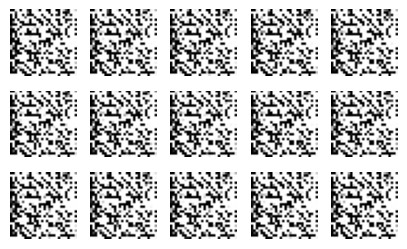

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  1%|          | 1/94 [00:00<00:39,  2.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  2%|▏         | 2/94 [00:00<00:45,  2.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  3%|▎         | 3/94 [00:01<00:47,  1.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▍         | 4/94 [00:02<00:46,  1.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  5%|▌         | 5/94 [00:02<00:47,  1.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  6%|▋         | 6/94 [00:03<00:48,  1.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  7%|▋         | 7/94 [00:03<00:43,  2.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  9%|▊         | 8/94 [00:03<00:39,  2.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|▉         | 9/94 [00:04<00:36,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 11%|█         | 10/94 [00:04<00:34,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 12%|█▏        | 11/94 [00:05<00:33,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 13%|█▎        | 12/94 [00:05<00:31,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 14%|█▍        | 13/94 [00:05<00:31,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 15%|█▍        | 14/94 [00:06<00:30,  2.64it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 16%|█▌        | 15/94 [00:06<00:29,  2.67it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 17%|█▋        | 16/94 [00:06<00:29,  2.67it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 18%|█▊        | 17/94 [00:07<00:28,  2.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|█▉        | 18/94 [00:07<00:28,  2.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 20%|██        | 19/94 [00:07<00:27,  2.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 21%|██▏       | 20/94 [00:08<00:27,  2.71it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|██▏       | 21/94 [00:08<00:26,  2.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 23%|██▎       | 22/94 [00:09<00:26,  2.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 24%|██▍       | 23/94 [00:09<00:26,  2.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 26%|██▌       | 24/94 [00:09<00:25,  2.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 27%|██▋       | 25/94 [00:10<00:25,  2.71it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 28%|██▊       | 26/94 [00:10<00:24,  2.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 29%|██▊       | 27/94 [00:10<00:24,  2.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 30%|██▉       | 28/94 [00:11<00:24,  2.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|███       | 29/94 [00:11<00:23,  2.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 32%|███▏      | 30/94 [00:12<00:23,  2.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 33%|███▎      | 31/94 [00:12<00:23,  2.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 34%|███▍      | 32/94 [00:12<00:23,  2.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 35%|███▌      | 33/94 [00:13<00:22,  2.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 36%|███▌      | 34/94 [00:13<00:24,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 37%|███▋      | 35/94 [00:14<00:26,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 38%|███▊      | 36/94 [00:14<00:27,  2.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 39%|███▉      | 37/94 [00:15<00:28,  2.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 40%|████      | 38/94 [00:15<00:29,  1.91it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 41%|████▏     | 39/94 [00:16<00:28,  1.96it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 40/94 [00:16<00:25,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 44%|████▎     | 41/94 [00:17<00:23,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 45%|████▍     | 42/94 [00:17<00:22,  2.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████▌     | 43/94 [00:17<00:20,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 47%|████▋     | 44/94 [00:18<00:19,  2.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 48%|████▊     | 45/94 [00:18<00:19,  2.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▉     | 46/94 [00:18<00:18,  2.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 50%|█████     | 47/94 [00:19<00:18,  2.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 48/94 [00:19<00:17,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 52%|█████▏    | 49/94 [00:20<00:17,  2.63it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 53%|█████▎    | 50/94 [00:20<00:16,  2.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 54%|█████▍    | 51/94 [00:20<00:16,  2.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 55%|█████▌    | 52/94 [00:21<00:15,  2.67it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 56%|█████▋    | 53/94 [00:21<00:15,  2.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 57%|█████▋    | 54/94 [00:21<00:14,  2.67it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 59%|█████▊    | 55/94 [00:22<00:14,  2.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 60%|█████▉    | 56/94 [00:22<00:14,  2.67it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 61%|██████    | 57/94 [00:23<00:13,  2.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|██████▏   | 58/94 [00:23<00:13,  2.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████▎   | 59/94 [00:23<00:13,  2.64it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 64%|██████▍   | 60/94 [00:24<00:12,  2.64it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|██████▍   | 61/94 [00:24<00:12,  2.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 66%|██████▌   | 62/94 [00:24<00:12,  2.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 67%|██████▋   | 63/94 [00:25<00:11,  2.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 64/94 [00:25<00:11,  2.64it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 69%|██████▉   | 65/94 [00:26<00:10,  2.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 70%|███████   | 66/94 [00:26<00:11,  2.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|███████▏  | 67/94 [00:27<00:12,  2.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 72%|███████▏  | 68/94 [00:27<00:12,  2.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 73%|███████▎  | 69/94 [00:28<00:12,  1.98it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 74%|███████▍  | 70/94 [00:28<00:12,  1.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 76%|███████▌  | 71/94 [00:29<00:11,  1.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|███████▋  | 72/94 [00:29<00:10,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|███████▊  | 73/94 [00:30<00:09,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████▊  | 74/94 [00:30<00:08,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 80%|███████▉  | 75/94 [00:30<00:07,  2.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 76/94 [00:31<00:07,  2.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 82%|████████▏ | 77/94 [00:31<00:06,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|████████▎ | 78/94 [00:31<00:06,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▍ | 79/94 [00:32<00:05,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 85%|████████▌ | 80/94 [00:32<00:05,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 86%|████████▌ | 81/94 [00:33<00:05,  2.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 87%|████████▋ | 82/94 [00:33<00:04,  2.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 88%|████████▊ | 83/94 [00:33<00:04,  2.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 89%|████████▉ | 84/94 [00:34<00:03,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 90%|█████████ | 85/94 [00:34<00:03,  2.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 91%|█████████▏| 86/94 [00:35<00:03,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 93%|█████████▎| 87/94 [00:35<00:02,  2.63it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 94%|█████████▎| 88/94 [00:35<00:02,  2.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 95%|█████████▍| 89/94 [00:36<00:01,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 96%|█████████▌| 90/94 [00:36<00:01,  2.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 97%|█████████▋| 91/94 [00:36<00:01,  2.63it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 98%|█████████▊| 92/94 [00:37<00:00,  2.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 99%|█████████▉| 93/94 [00:37<00:00,  2.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


100%|██████████| 94/94 [00:38<00:00,  2.47it/s]

Epoch: 7/100 	 Discriminator Loss: 1.080     Generator Loss: 1.080
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


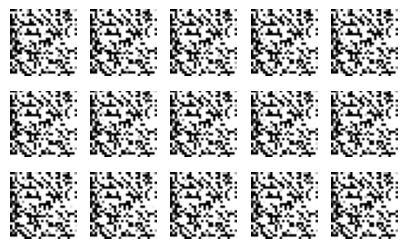

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 1/94 [00:00<00:37,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  2%|▏         | 2/94 [00:00<00:40,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  3%|▎         | 3/94 [00:01<00:44,  2.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▍         | 4/94 [00:02<00:47,  1.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  5%|▌         | 5/94 [00:02<00:49,  1.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  6%|▋         | 6/94 [00:03<00:49,  1.76it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  7%|▋         | 7/94 [00:03<00:46,  1.86it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▊         | 8/94 [00:04<00:42,  2.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|▉         | 9/94 [00:04<00:38,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 11%|█         | 10/94 [00:04<00:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 12%|█▏        | 11/94 [00:05<00:34,  2.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 13%|█▎        | 12/94 [00:05<00:33,  2.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 14%|█▍        | 13/94 [00:05<00:32,  2.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 15%|█▍        | 14/94 [00:06<00:31,  2.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 16%|█▌        | 15/94 [00:06<00:30,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 17%|█▋        | 16/94 [00:07<00:30,  2.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 18%|█▊        | 17/94 [00:07<00:30,  2.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 19%|█▉        | 18/94 [00:07<00:29,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 20%|██        | 19/94 [00:08<00:29,  2.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 21%|██▏       | 20/94 [00:08<00:28,  2.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 22%|██▏       | 21/94 [00:09<00:28,  2.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 23%|██▎       | 22/94 [00:09<00:28,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 24%|██▍       | 23/94 [00:09<00:27,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 26%|██▌       | 24/94 [00:10<00:27,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 27%|██▋       | 25/94 [00:10<00:27,  2.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 26/94 [00:11<00:26,  2.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 29%|██▊       | 27/94 [00:11<00:26,  2.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 30%|██▉       | 28/94 [00:11<00:25,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 31%|███       | 29/94 [00:12<00:35,  1.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 32%|███▏      | 30/94 [00:13<00:31,  2.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|███▎      | 31/94 [00:13<00:29,  2.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 34%|███▍      | 32/94 [00:14<00:31,  1.99it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 35%|███▌      | 33/94 [00:14<00:31,  1.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|███▌      | 34/94 [00:15<00:32,  1.86it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|███▋      | 35/94 [00:15<00:32,  1.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 38%|███▊      | 36/94 [00:16<00:31,  1.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 39%|███▉      | 37/94 [00:16<00:28,  2.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 40%|████      | 38/94 [00:17<00:25,  2.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 41%|████▏     | 39/94 [00:17<00:24,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 43%|████▎     | 40/94 [00:17<00:22,  2.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 44%|████▎     | 41/94 [00:18<00:21,  2.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 45%|████▍     | 42/94 [00:18<00:20,  2.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 46%|████▌     | 43/94 [00:19<00:20,  2.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 47%|████▋     | 44/94 [00:19<00:19,  2.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 48%|████▊     | 45/94 [00:19<00:19,  2.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 49%|████▉     | 46/94 [00:20<00:18,  2.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 50%|█████     | 47/94 [00:20<00:18,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 48/94 [00:20<00:17,  2.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 52%|█████▏    | 49/94 [00:21<00:17,  2.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 53%|█████▎    | 50/94 [00:21<00:17,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 54%|█████▍    | 51/94 [00:22<00:16,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|█████▌    | 52/94 [00:22<00:16,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 56%|█████▋    | 53/94 [00:22<00:15,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████▋    | 54/94 [00:23<00:15,  2.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 59%|█████▊    | 55/94 [00:23<00:15,  2.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 60%|█████▉    | 56/94 [00:24<00:14,  2.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|██████    | 57/94 [00:24<00:14,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|██████▏   | 58/94 [00:24<00:14,  2.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████▎   | 59/94 [00:25<00:13,  2.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 64%|██████▍   | 60/94 [00:25<00:13,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|██████▍   | 61/94 [00:26<00:13,  2.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|██████▌   | 62/94 [00:26<00:14,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 67%|██████▋   | 63/94 [00:27<00:14,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 68%|██████▊   | 64/94 [00:27<00:15,  1.99it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 69%|██████▉   | 65/94 [00:28<00:15,  1.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|███████   | 66/94 [00:28<00:15,  1.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|███████▏  | 67/94 [00:29<00:13,  1.97it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 72%|███████▏  | 68/94 [00:29<00:12,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|███████▎  | 69/94 [00:30<00:11,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 74%|███████▍  | 70/94 [00:30<00:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 76%|███████▌  | 71/94 [00:30<00:09,  2.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 77%|███████▋  | 72/94 [00:31<00:09,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 78%|███████▊  | 73/94 [00:31<00:08,  2.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 79%|███████▊  | 74/94 [00:32<00:08,  2.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 80%|███████▉  | 75/94 [00:32<00:07,  2.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 76/94 [00:32<00:07,  2.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|████████▏ | 77/94 [00:33<00:06,  2.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|████████▎ | 78/94 [00:33<00:06,  2.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 84%|████████▍ | 79/94 [00:34<00:05,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 85%|████████▌ | 80/94 [00:34<00:05,  2.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 86%|████████▌ | 81/94 [00:34<00:05,  2.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 87%|████████▋ | 82/94 [00:35<00:04,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 88%|████████▊ | 83/94 [00:35<00:04,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 89%|████████▉ | 84/94 [00:36<00:03,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 90%|█████████ | 85/94 [00:36<00:03,  2.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 91%|█████████▏| 86/94 [00:36<00:03,  2.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 93%|█████████▎| 87/94 [00:37<00:02,  2.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 94%|█████████▎| 88/94 [00:37<00:02,  2.47it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 95%|█████████▍| 89/94 [00:38<00:02,  2.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 96%|█████████▌| 90/94 [00:38<00:01,  2.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 97%|█████████▋| 91/94 [00:38<00:01,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 98%|█████████▊| 92/94 [00:39<00:00,  2.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 99%|█████████▉| 93/94 [00:40<00:00,  2.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


100%|██████████| 94/94 [00:40<00:00,  2.31it/s]

Epoch: 8/100 	 Discriminator Loss: 1.099     Generator Loss: 1.099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


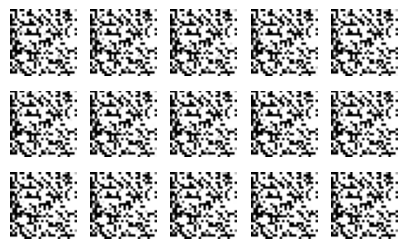

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  1%|          | 1/94 [00:00<00:54,  1.71it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  2%|▏         | 2/94 [00:00<00:44,  2.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  3%|▎         | 3/94 [00:01<00:40,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  4%|▍         | 4/94 [00:01<00:38,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  5%|▌         | 5/94 [00:02<00:36,  2.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  6%|▋         | 6/94 [00:02<00:36,  2.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  7%|▋         | 7/94 [00:02<00:35,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  9%|▊         | 8/94 [00:03<00:34,  2.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|▉         | 9/94 [00:03<00:34,  2.46it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 11%|█         | 10/94 [00:04<00:33,  2.47it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 12%|█▏        | 11/94 [00:04<00:33,  2.47it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|█▎        | 12/94 [00:04<00:33,  2.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 14%|█▍        | 13/94 [00:05<00:32,  2.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 15%|█▍        | 14/94 [00:05<00:31,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 16%|█▌        | 15/94 [00:06<00:31,  2.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 17%|█▋        | 16/94 [00:06<00:31,  2.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 18%|█▊        | 17/94 [00:07<00:31,  2.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 19%|█▉        | 18/94 [00:07<00:30,  2.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 20%|██        | 19/94 [00:07<00:30,  2.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 21%|██▏       | 20/94 [00:08<00:30,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 22%|██▏       | 21/94 [00:08<00:29,  2.46it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 23%|██▎       | 22/94 [00:09<00:29,  2.47it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 24%|██▍       | 23/94 [00:09<00:28,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 26%|██▌       | 24/94 [00:09<00:28,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 27%|██▋       | 25/94 [00:10<00:28,  2.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 28%|██▊       | 26/94 [00:10<00:29,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 29%|██▊       | 27/94 [00:11<00:32,  2.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 30%|██▉       | 28/94 [00:11<00:33,  1.97it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 31%|███       | 29/94 [00:12<00:34,  1.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 32%|███▏      | 30/94 [00:13<00:35,  1.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 33%|███▎      | 31/94 [00:13<00:34,  1.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 34%|███▍      | 32/94 [00:14<00:31,  1.97it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 35%|███▌      | 33/94 [00:14<00:29,  2.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|███▌      | 34/94 [00:14<00:27,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 37%|███▋      | 35/94 [00:15<00:26,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 38%|███▊      | 36/94 [00:15<00:25,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 39%|███▉      | 37/94 [00:16<00:24,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|████      | 38/94 [00:16<00:23,  2.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 41%|████▏     | 39/94 [00:16<00:22,  2.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 43%|████▎     | 40/94 [00:17<00:23,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 44%|████▎     | 41/94 [00:17<00:22,  2.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 45%|████▍     | 42/94 [00:18<00:21,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 46%|████▌     | 43/94 [00:18<00:21,  2.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 47%|████▋     | 44/94 [00:19<00:20,  2.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 48%|████▊     | 45/94 [00:19<00:20,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 49%|████▉     | 46/94 [00:19<00:20,  2.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 50%|█████     | 47/94 [00:20<00:19,  2.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 48/94 [00:20<00:19,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 52%|█████▏    | 49/94 [00:21<00:18,  2.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 53%|█████▎    | 50/94 [00:21<00:18,  2.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 54%|█████▍    | 51/94 [00:21<00:17,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 55%|█████▌    | 52/94 [00:22<00:17,  2.47it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 56%|█████▋    | 53/94 [00:22<00:16,  2.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████▋    | 54/94 [00:23<00:16,  2.47it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 59%|█████▊    | 55/94 [00:23<00:15,  2.46it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 60%|█████▉    | 56/94 [00:24<00:17,  2.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 61%|██████    | 57/94 [00:24<00:18,  1.99it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 62%|██████▏   | 58/94 [00:25<00:19,  1.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 63%|██████▎   | 59/94 [00:25<00:19,  1.78it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 64%|██████▍   | 60/94 [00:26<00:19,  1.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 65%|██████▍   | 61/94 [00:26<00:17,  1.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|██████▌   | 62/94 [00:27<00:15,  2.03it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 67%|██████▋   | 63/94 [00:27<00:14,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 68%|██████▊   | 64/94 [00:28<00:13,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 69%|██████▉   | 65/94 [00:28<00:12,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 70%|███████   | 66/94 [00:29<00:12,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|███████▏  | 67/94 [00:29<00:11,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|███████▏  | 68/94 [00:29<00:11,  2.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|███████▎  | 69/94 [00:30<00:10,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 74%|███████▍  | 70/94 [00:30<00:10,  2.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|███████▌  | 71/94 [00:31<00:09,  2.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 77%|███████▋  | 72/94 [00:31<00:09,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|███████▊  | 73/94 [00:31<00:08,  2.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████▊  | 74/94 [00:32<00:08,  2.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 80%|███████▉  | 75/94 [00:32<00:07,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 76/94 [00:33<00:07,  2.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 82%|████████▏ | 77/94 [00:33<00:06,  2.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 83%|████████▎ | 78/94 [00:33<00:06,  2.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▍ | 79/94 [00:34<00:06,  2.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|████████▌ | 80/94 [00:34<00:05,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 86%|████████▌ | 81/94 [00:35<00:05,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 87%|████████▋ | 82/94 [00:35<00:04,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 88%|████████▊ | 83/94 [00:36<00:04,  2.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 89%|████████▉ | 84/94 [00:36<00:04,  2.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 90%|█████████ | 85/94 [00:37<00:04,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 91%|█████████▏| 86/94 [00:37<00:04,  1.98it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 93%|█████████▎| 87/94 [00:38<00:03,  1.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 94%|█████████▎| 88/94 [00:38<00:03,  1.76it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 95%|█████████▍| 89/94 [00:39<00:02,  1.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 96%|█████████▌| 90/94 [00:39<00:02,  1.95it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 97%|█████████▋| 91/94 [00:40<00:01,  2.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 98%|█████████▊| 92/94 [00:40<00:00,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 99%|█████████▉| 93/94 [00:41<00:00,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


100%|██████████| 94/94 [00:41<00:00,  2.26it/s]

Epoch: 9/100 	 Discriminator Loss: 1.114     Generator Loss: 1.114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


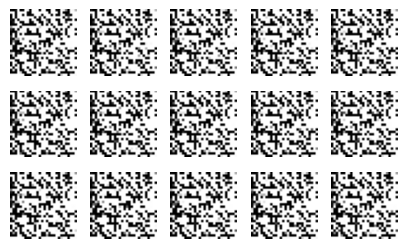

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  1%|          | 1/94 [00:00<00:43,  2.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  2%|▏         | 2/94 [00:00<00:40,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  3%|▎         | 3/94 [00:01<00:39,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  4%|▍         | 4/94 [00:01<00:38,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  5%|▌         | 5/94 [00:02<00:37,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  6%|▋         | 6/94 [00:02<00:37,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 7/94 [00:03<00:37,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  9%|▊         | 8/94 [00:03<00:36,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 10%|▉         | 9/94 [00:03<00:36,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 11%|█         | 10/94 [00:04<00:36,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 12%|█▏        | 11/94 [00:04<00:35,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 13%|█▎        | 12/94 [00:05<00:34,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 14%|█▍        | 13/94 [00:05<00:34,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 15%|█▍        | 14/94 [00:05<00:33,  2.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 16%|█▌        | 15/94 [00:06<00:33,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 17%|█▋        | 16/94 [00:06<00:32,  2.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 18%|█▊        | 17/94 [00:07<00:32,  2.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 19%|█▉        | 18/94 [00:07<00:35,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 20%|██        | 19/94 [00:08<00:38,  1.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 21%|██▏       | 20/94 [00:09<00:40,  1.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 22%|██▏       | 21/94 [00:09<00:40,  1.78it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 23%|██▎       | 22/94 [00:10<00:41,  1.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 24%|██▍       | 23/94 [00:10<00:39,  1.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 26%|██▌       | 24/94 [00:11<00:36,  1.92it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|██▋       | 25/94 [00:11<00:34,  2.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 28%|██▊       | 26/94 [00:12<00:32,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 29%|██▊       | 27/94 [00:12<00:31,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 30%|██▉       | 28/94 [00:12<00:29,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 31%|███       | 29/94 [00:13<00:28,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 32%|███▏      | 30/94 [00:13<00:28,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 33%|███▎      | 31/94 [00:14<00:27,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 34%|███▍      | 32/94 [00:14<00:27,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 35%|███▌      | 33/94 [00:15<00:26,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 36%|███▌      | 34/94 [00:15<00:25,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 37%|███▋      | 35/94 [00:15<00:25,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 38%|███▊      | 36/94 [00:16<00:24,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 39%|███▉      | 37/94 [00:16<00:24,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|████      | 38/94 [00:17<00:23,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 41%|████▏     | 39/94 [00:17<00:23,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 43%|████▎     | 40/94 [00:18<00:23,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 44%|████▎     | 41/94 [00:18<00:22,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 45%|████▍     | 42/94 [00:18<00:22,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 46%|████▌     | 43/94 [00:19<00:21,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 47%|████▋     | 44/94 [00:19<00:21,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 48%|████▊     | 45/94 [00:20<00:21,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 49%|████▉     | 46/94 [00:20<00:21,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 50%|█████     | 47/94 [00:21<00:23,  2.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 48/94 [00:21<00:24,  1.90it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 52%|█████▏    | 49/94 [00:22<00:25,  1.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 53%|█████▎    | 50/94 [00:23<00:25,  1.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 54%|█████▍    | 51/94 [00:23<00:25,  1.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 55%|█████▌    | 52/94 [00:24<00:22,  1.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 56%|█████▋    | 53/94 [00:24<00:20,  1.97it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 57%|█████▋    | 54/94 [00:25<00:19,  2.05it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 59%|█████▊    | 55/94 [00:25<00:18,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 60%|█████▉    | 56/94 [00:25<00:17,  2.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 61%|██████    | 57/94 [00:26<00:16,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|██████▏   | 58/94 [00:26<00:15,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████▎   | 59/94 [00:27<00:15,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 64%|██████▍   | 60/94 [00:27<00:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|██████▍   | 61/94 [00:28<00:14,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|██████▌   | 62/94 [00:28<00:13,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 67%|██████▋   | 63/94 [00:28<00:13,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 64/94 [00:29<00:12,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 69%|██████▉   | 65/94 [00:29<00:12,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|███████   | 66/94 [00:30<00:12,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 71%|███████▏  | 67/94 [00:30<00:11,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|███████▏  | 68/94 [00:31<00:11,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|███████▎  | 69/94 [00:31<00:10,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 74%|███████▍  | 70/94 [00:32<00:10,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|███████▌  | 71/94 [00:32<00:10,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|███████▋  | 72/94 [00:32<00:09,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|███████▊  | 73/94 [00:33<00:09,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████▊  | 74/94 [00:33<00:09,  2.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 80%|███████▉  | 75/94 [00:34<00:10,  1.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 81%|████████  | 76/94 [00:35<00:09,  1.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 82%|████████▏ | 77/94 [00:35<00:09,  1.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|████████▎ | 78/94 [00:36<00:09,  1.65it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 84%|████████▍ | 79/94 [00:37<00:08,  1.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 85%|████████▌ | 80/94 [00:37<00:07,  1.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 86%|████████▌ | 81/94 [00:38<00:08,  1.46it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 87%|████████▋ | 82/94 [00:38<00:07,  1.65it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 88%|████████▊ | 83/94 [00:39<00:06,  1.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 89%|████████▉ | 84/94 [00:39<00:05,  1.92it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 90%|█████████ | 85/94 [00:40<00:04,  2.03it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 91%|█████████▏| 86/94 [00:40<00:03,  2.07it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 93%|█████████▎| 87/94 [00:41<00:03,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 94%|█████████▎| 88/94 [00:41<00:02,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 95%|█████████▍| 89/94 [00:42<00:02,  2.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 96%|█████████▌| 90/94 [00:42<00:01,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 97%|█████████▋| 91/94 [00:42<00:01,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 98%|█████████▊| 92/94 [00:43<00:00,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 99%|█████████▉| 93/94 [00:43<00:00,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


100%|██████████| 94/94 [00:44<00:00,  2.13it/s]

Epoch: 10/100 	 Discriminator Loss: 1.127     Generator Loss: 1.127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


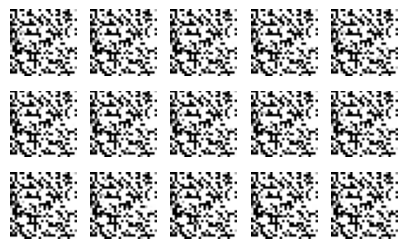

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  1%|          | 1/94 [00:00<00:48,  1.91it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  2%|▏         | 2/94 [00:00<00:43,  2.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  3%|▎         | 3/94 [00:01<00:41,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  4%|▍         | 4/94 [00:01<00:40,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  5%|▌         | 5/94 [00:02<00:40,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  6%|▋         | 6/94 [00:02<00:44,  1.96it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  7%|▋         | 7/94 [00:03<00:47,  1.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▊         | 8/94 [00:04<00:49,  1.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 10%|▉         | 9/94 [00:04<00:51,  1.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 11%|█         | 10/94 [00:05<00:49,  1.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 12%|█▏        | 11/94 [00:05<00:44,  1.85it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 13%|█▎        | 12/94 [00:06<00:41,  1.95it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 14%|█▍        | 13/94 [00:06<00:40,  2.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 15%|█▍        | 14/94 [00:07<00:38,  2.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 16%|█▌        | 15/94 [00:07<00:37,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 17%|█▋        | 16/94 [00:08<00:35,  2.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 18%|█▊        | 17/94 [00:08<00:35,  2.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 19%|█▉        | 18/94 [00:08<00:34,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 20%|██        | 19/94 [00:09<00:33,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 21%|██▏       | 20/94 [00:09<00:33,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 22%|██▏       | 21/94 [00:10<00:32,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 23%|██▎       | 22/94 [00:10<00:32,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 24%|██▍       | 23/94 [00:11<00:31,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 26%|██▌       | 24/94 [00:11<00:31,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 27%|██▋       | 25/94 [00:12<00:31,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 28%|██▊       | 26/94 [00:12<00:30,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|██▊       | 27/94 [00:12<00:30,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 30%|██▉       | 28/94 [00:13<00:29,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|███       | 29/94 [00:13<00:28,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 32%|███▏      | 30/94 [00:14<00:28,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|███▎      | 31/94 [00:14<00:28,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███▍      | 32/94 [00:15<00:27,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 35%|███▌      | 33/94 [00:15<00:31,  1.96it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 36%|███▌      | 34/94 [00:16<00:33,  1.78it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 37%|███▋      | 35/94 [00:17<00:35,  1.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 38%|███▊      | 36/94 [00:17<00:36,  1.60it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 39%|███▉      | 37/94 [00:18<00:34,  1.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|████      | 38/94 [00:18<00:30,  1.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 41%|████▏     | 39/94 [00:19<00:28,  1.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 43%|████▎     | 40/94 [00:19<00:27,  1.99it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 44%|████▎     | 41/94 [00:20<00:25,  2.05it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 45%|████▍     | 42/94 [00:20<00:24,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████▌     | 43/94 [00:21<00:23,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 47%|████▋     | 44/94 [00:21<00:22,  2.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 48%|████▊     | 45/94 [00:22<00:22,  2.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▉     | 46/94 [00:22<00:21,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 50%|█████     | 47/94 [00:22<00:21,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 48/94 [00:23<00:20,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 52%|█████▏    | 49/94 [00:23<00:20,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 53%|█████▎    | 50/94 [00:24<00:19,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 54%|█████▍    | 51/94 [00:24<00:19,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|█████▌    | 52/94 [00:25<00:18,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|█████▋    | 53/94 [00:25<00:18,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████▋    | 54/94 [00:26<00:18,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 59%|█████▊    | 55/94 [00:26<00:17,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 60%|█████▉    | 56/94 [00:26<00:17,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|██████    | 57/94 [00:27<00:16,  2.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|██████▏   | 58/94 [00:27<00:16,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████▎   | 59/94 [00:28<00:16,  2.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 64%|██████▍   | 60/94 [00:29<00:17,  1.92it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 65%|██████▍   | 61/94 [00:29<00:18,  1.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 66%|██████▌   | 62/94 [00:30<00:18,  1.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 67%|██████▋   | 63/94 [00:31<00:18,  1.64it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 64/94 [00:31<00:16,  1.78it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 69%|██████▉   | 65/94 [00:31<00:15,  1.91it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|███████   | 66/94 [00:32<00:14,  1.98it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|███████▏  | 67/94 [00:32<00:13,  2.05it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|███████▏  | 68/94 [00:33<00:12,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 73%|███████▎  | 69/94 [00:33<00:11,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 74%|███████▍  | 70/94 [00:34<00:11,  2.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 76%|███████▌  | 71/94 [00:34<00:10,  2.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|███████▋  | 72/94 [00:35<00:10,  2.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|███████▊  | 73/94 [00:35<00:09,  2.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████▊  | 74/94 [00:35<00:09,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 80%|███████▉  | 75/94 [00:36<00:08,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 76/94 [00:36<00:08,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|████████▏ | 77/94 [00:37<00:07,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|████████▎ | 78/94 [00:37<00:07,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 84%|████████▍ | 79/94 [00:38<00:06,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|████████▌ | 80/94 [00:38<00:06,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 86%|████████▌ | 81/94 [00:39<00:05,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 87%|████████▋ | 82/94 [00:39<00:05,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 88%|████████▊ | 83/94 [00:40<00:04,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 89%|████████▉ | 84/94 [00:40<00:04,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 90%|█████████ | 85/94 [00:40<00:04,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 91%|█████████▏| 86/94 [00:41<00:04,  1.95it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 93%|█████████▎| 87/94 [00:42<00:03,  1.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 94%|█████████▎| 88/94 [00:42<00:03,  1.71it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 95%|█████████▍| 89/94 [00:43<00:03,  1.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 96%|█████████▌| 90/94 [00:44<00:02,  1.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 97%|█████████▋| 91/94 [00:44<00:01,  1.85it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 98%|█████████▊| 92/94 [00:45<00:01,  1.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 99%|█████████▉| 93/94 [00:45<00:00,  2.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


100%|██████████| 94/94 [00:45<00:00,  2.05it/s]

Epoch: 11/100 	 Discriminator Loss: 1.138     Generator Loss: 1.138
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


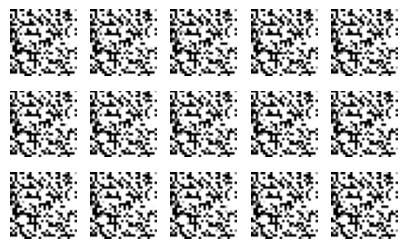

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  1%|          | 1/94 [00:00<00:47,  1.98it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  2%|▏         | 2/94 [00:00<00:43,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  3%|▎         | 3/94 [00:01<00:42,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  4%|▍         | 4/94 [00:01<00:42,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  5%|▌         | 5/94 [00:02<00:41,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  6%|▋         | 6/94 [00:02<00:41,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  7%|▋         | 7/94 [00:03<00:40,  2.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  9%|▊         | 8/94 [00:03<00:40,  2.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|▉         | 9/94 [00:04<00:39,  2.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 11%|█         | 10/94 [00:04<00:39,  2.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 12%|█▏        | 11/94 [00:05<00:38,  2.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|█▎        | 12/94 [00:05<00:37,  2.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 14%|█▍        | 13/94 [00:06<00:37,  2.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 15%|█▍        | 14/94 [00:06<00:36,  2.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 16%|█▌        | 15/94 [00:06<00:36,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 17%|█▋        | 16/94 [00:07<00:37,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 18%|█▊        | 17/94 [00:08<00:40,  1.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 19%|█▉        | 18/94 [00:08<00:43,  1.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 20%|██        | 19/94 [00:09<00:46,  1.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 21%|██▏       | 20/94 [00:10<00:47,  1.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 22%|██▏       | 21/94 [00:10<00:44,  1.65it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 23%|██▎       | 22/94 [00:11<00:40,  1.76it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 24%|██▍       | 23/94 [00:11<00:38,  1.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|██▌       | 24/94 [00:12<00:36,  1.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|██▋       | 25/94 [00:12<00:34,  2.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 28%|██▊       | 26/94 [00:13<00:33,  2.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 29%|██▊       | 27/94 [00:13<00:32,  2.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 30%|██▉       | 28/94 [00:14<00:31,  2.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 31%|███       | 29/94 [00:14<00:31,  2.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|███▏      | 30/94 [00:14<00:30,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 33%|███▎      | 31/94 [00:15<00:29,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 34%|███▍      | 32/94 [00:15<00:29,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 35%|███▌      | 33/94 [00:16<00:29,  2.07it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 36%|███▌      | 34/94 [00:16<00:28,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|███▋      | 35/94 [00:17<00:27,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 38%|███▊      | 36/94 [00:17<00:27,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 39%|███▉      | 37/94 [00:18<00:26,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 40%|████      | 38/94 [00:18<00:26,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 41%|████▏     | 39/94 [00:19<00:25,  2.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 40/94 [00:19<00:25,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 44%|████▎     | 41/94 [00:20<00:24,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 45%|████▍     | 42/94 [00:20<00:25,  2.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 46%|████▌     | 43/94 [00:21<00:27,  1.85it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|████▋     | 44/94 [00:22<00:28,  1.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 48%|████▊     | 45/94 [00:22<00:30,  1.63it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 49%|████▉     | 46/94 [00:23<00:30,  1.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 50%|█████     | 47/94 [00:23<00:28,  1.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 48/94 [00:24<00:25,  1.77it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 52%|█████▏    | 49/94 [00:24<00:23,  1.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 53%|█████▎    | 50/94 [00:25<00:22,  1.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 54%|█████▍    | 51/94 [00:25<00:21,  2.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|█████▌    | 52/94 [00:26<00:20,  2.03it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|█████▋    | 53/94 [00:26<00:19,  2.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 57%|█████▋    | 54/94 [00:27<00:19,  2.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 59%|█████▊    | 55/94 [00:27<00:18,  2.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 60%|█████▉    | 56/94 [00:28<00:18,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|██████    | 57/94 [00:28<00:17,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 62%|██████▏   | 58/94 [00:29<00:16,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████▎   | 59/94 [00:29<00:16,  2.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 64%|██████▍   | 60/94 [00:30<00:15,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 65%|██████▍   | 61/94 [00:30<00:15,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|██████▌   | 62/94 [00:30<00:14,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 67%|██████▋   | 63/94 [00:31<00:14,  2.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 64/94 [00:31<00:14,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 69%|██████▉   | 65/94 [00:32<00:13,  2.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|███████   | 66/94 [00:32<00:13,  2.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|███████▏  | 67/94 [00:33<00:12,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|███████▏  | 68/94 [00:33<00:13,  1.95it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 73%|███████▎  | 69/94 [00:34<00:14,  1.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 74%|███████▍  | 70/94 [00:35<00:14,  1.67it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|███████▌  | 71/94 [00:35<00:14,  1.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 77%|███████▋  | 72/94 [00:36<00:13,  1.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 78%|███████▊  | 73/94 [00:37<00:12,  1.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████▊  | 74/94 [00:37<00:10,  1.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 80%|███████▉  | 75/94 [00:38<00:09,  1.91it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 76/94 [00:38<00:09,  1.98it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|████████▏ | 77/94 [00:38<00:08,  2.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|████████▎ | 78/94 [00:39<00:07,  2.05it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▍ | 79/94 [00:39<00:07,  2.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 85%|████████▌ | 80/94 [00:40<00:06,  2.07it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 86%|████████▌ | 81/94 [00:40<00:06,  2.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 87%|████████▋ | 82/94 [00:41<00:05,  2.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 88%|████████▊ | 83/94 [00:41<00:05,  2.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 89%|████████▉ | 84/94 [00:42<00:04,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 90%|█████████ | 85/94 [00:42<00:04,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 91%|█████████▏| 86/94 [00:43<00:03,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 93%|█████████▎| 87/94 [00:43<00:03,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 94%|█████████▎| 88/94 [00:44<00:02,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 95%|█████████▍| 89/94 [00:44<00:02,  2.07it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 96%|█████████▌| 90/94 [00:45<00:01,  2.07it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 97%|█████████▋| 91/94 [00:45<00:01,  2.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 98%|█████████▊| 92/94 [00:46<00:00,  2.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 99%|█████████▉| 93/94 [00:46<00:00,  2.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


100%|██████████| 94/94 [00:47<00:00,  1.99it/s]

Epoch: 12/100 	 Discriminator Loss: 1.148     Generator Loss: 1.148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


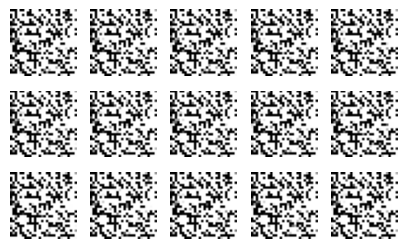

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 0/94 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [31]:
from tqdm import tqdm
for epoch in range(epochs):
    for batch in tqdm(range(steps_per_epoch)):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2 * batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)
        d_loss = d_loss[0] if isinstance(d_loss, list) else d_loss  # ตรวจสอบว่าเป็น list หรือไม่

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)
        g_loss = g_loss[0] if isinstance(g_loss, list) else g_loss  # ตรวจสอบว่าเป็น list หรือไม่

    print(f'Epoch: {epoch+1}/{epochs} \t Discriminator Loss: {d_loss:.3f} \
    Generator Loss: {g_loss:.3f}')
    dsp_img = (3, 5)
    noise = np.random.normal(0, 1, size=(dsp_img[0]*dsp_img[1], noise_dim))
    show_images(noise, dsp_img)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


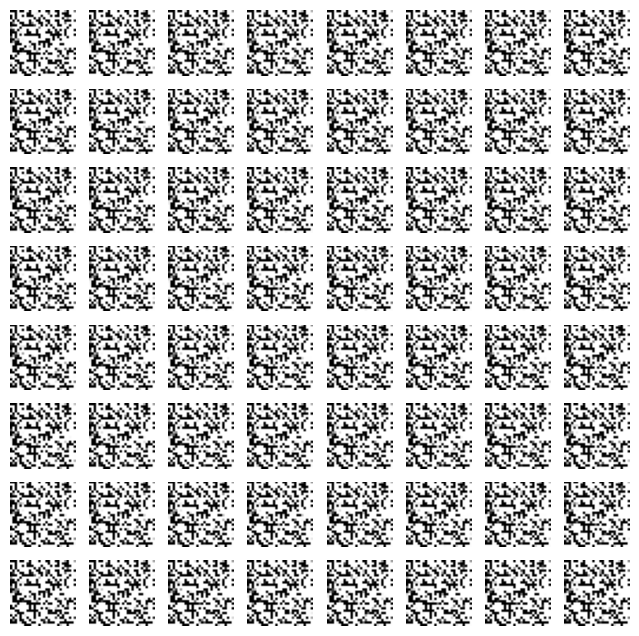

In [32]:
noise = np.random.normal(0, 1, size=(64, noise_dim))
show_images(noise, (8, 8))